<a href="https://colab.research.google.com/github/jxin11/waste-image-classification/blob/main/Waste_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Import Libraries

In [ ]:
pip install visualkeras

In [ ]:
pip install helper

In [3]:
import os
import cv2
import glob
import random
import pickle
import visualkeras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from keras.utils import np_utils
from collections import Counter, OrderedDict
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Optimizer, Adam, SGD, RMSprop, Adagrad, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                                    Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Read & Store Images

In [ ]:
!git clone https://github.com/garythung/trashnet

In [ ]:
!unzip /content/trashnet/data/dataset-resized.zip

In [6]:
SIZE = 128

filepath = []
images = []
labels = []

# Read & Sort filepath
for folder_path in glob.glob("/content/dataset-resized/*"):
  for img_path in glob.glob(folder_path + "/*.jpg"):
    filepath.append(img_path)
  
filepath.sort()

# Read images & labels
for img_path in filepath:
  label = img_path.split("/")[-2]
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))   # Resize image
  images.append(img)
  labels.append(label)

In [ ]:
print("Total no. of images: ", len(images))
print("Total no. of labels: ", len(labels))
print("Total no. of unique labels: ", Counter(labels))

Total no. of images:  2527
Total no. of labels:  2527
Total no. of unique labels:  Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


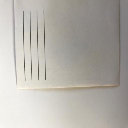

paper


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

# Prepare Train & Test Sets

In [7]:
# Shuffle images
temp = list(zip(images, labels))
random.Random(0).shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

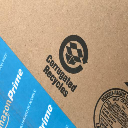

cardboard


In [ ]:
i = 1327
cv2_imshow(images[i])
print(labels[i])

In [8]:
# Train test split
img_train, img_test, label_train, label_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=11)  # 132

In [ ]:
print(len(img_train))
print(len(img_test))

2021
506


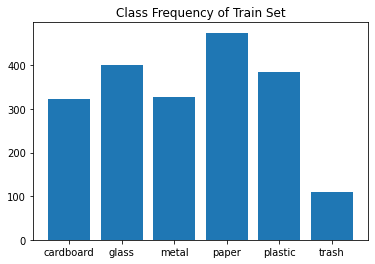


Train Set
cardboard: 322 (15.93%)
glass: 401 (19.84%)
metal: 328 (16.23%)
paper: 475 (23.5%)
plastic: 385 (19.05%)
trash: 110 (5.44%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(label_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

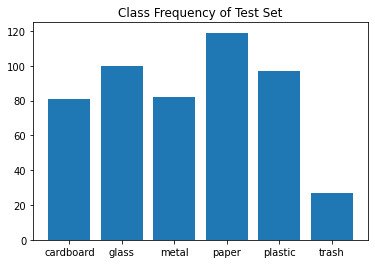


Test Set
cardboard: 81 (16.01%)
glass: 100 (19.76%)
metal: 82 (16.21%)
paper: 119 (23.52%)
plastic: 97 (19.17%)
trash: 27 (5.34%)


In [ ]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(label_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Convert to numpy array

In [ ]:
# Before conversion
print("X_train: ", "type-", type(img_train), "; size-", len(img_train))
print("y_train: ", "type-", type(label_train), "; size-", len(label_train))

X_train:  type- <class 'list'> ; size- 2021
y_train:  type- <class 'list'> ; size- 2021


In [9]:
img_train = np.array(img_train, dtype="float")
img_test = np.array(img_test, dtype="float")
label_train = np.array(label_train)
label_test = np.array(label_test)

In [ ]:
# After conversion
print("X_train: ", "type-", type(img_train), "; size-", img_train.shape)
print("y_train: ", "type-", type(label_train), "; size-", label_train.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (2021, 128, 128, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (2021,)


# Label Encoding

In [10]:
le = preprocessing.LabelEncoder()
le.fit(label_train)

LabelEncoder()

In [11]:
label_encoded_train = le.transform(label_train)
label_encoded_test = le.transform(label_test)

In [ ]:
le.classes_

array(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      dtype='<U9')

# One Hot Encoding

In [12]:
n_classes = len(le.classes_)

print("Shape before OHE: ", label_encoded_train.shape)

label_encoded_train = np_utils.to_categorical(label_encoded_train,n_classes)
label_encoded_test = np_utils.to_categorical(label_encoded_test,n_classes)

print("Shape after OHE: ", label_encoded_train.shape)

Shape before OHE:  (2021,)
Shape after OHE:  (2021, 6)


# Normalization



In [13]:
img_train, img_test = img_train/255.0, img_test/255.0

# Data Augmentation
Ref: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

Data augmentation is only applied to train set.

In [ ]:
datagen = ImageDataGenerator(rotation_range=20, 
                             horizontal_flip=True, vertical_flip=True)
                             #zoom_range=0.2, shear_range=0.2, width_shift_range=0.2, height_shift_range=0.2)

**batch_size in ImageDataGenerator.flow - If you have 1000 images in your dataset and the batch size is defined as 10. Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.

Original Image: 


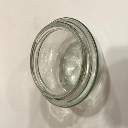


Data Augmentation: 


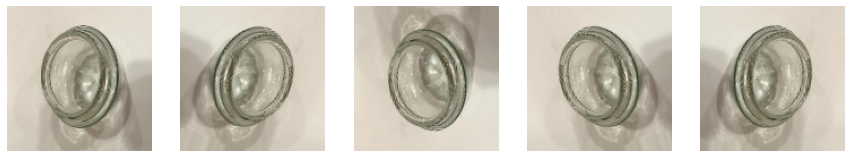

In [ ]:
# Take an image as example

print("Original Image: ")
cv2_imshow(img_train[123]*255)

width, height, channel = img_train.shape[1], img_train.shape[2], img_train.shape[3]
iter = datagen.flow((img_train[123]).reshape(1, width, height, channel), batch_size=1)

# generate samples and plot
print("\nData Augmentation: ")
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

# generate batch of images
for i in range(5):

  image = next(iter)
  image = np.squeeze(image)
  
  # plot image
  ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  ax[i].axis('off')

# Deep Learning Model Components
Ref: 
1. https://medium.com/the-owl/building-inception-resnet-v2-in-keras-from-scratch-a3546c4d93f0
2. https://arxiv.org/abs/1602.07261

## Convolutional Block

In [ ]:
def conv2d(x, filters, kernel_size, strides=1, pad='same', act=True, name=None):
  x = Conv2D(filters=filters, kernel_size=kernel_size,
             strides=strides, padding=pad,
             data_format='channels_last', use_bias=False,
             name=name+'conv2d')(x)
  x = BatchNormalization(axis=3, scale=False, name=name+'conv2d_bn')(x)
  if act:
    x = Activation('relu', name=name+'conv2d_act')(x)
  return x

Batch Norm reduces the internal covariate shift of the network. <br>
Batch Norm has a regularization effect. <br>
In CNN, each feature map will have a single mean and standard deviation. <br>
The original paper talks about applying batch norm just before the activation function, it has been found in practice that applying batch norm after the activation yields better results. <br>
Ref: 
1. https://www.baeldung.com/cs/batch-normalization-cnn
2. https://blog.paperspace.com/busting-the-myths-about-batch-normalization/

## Inception ResNet A Block

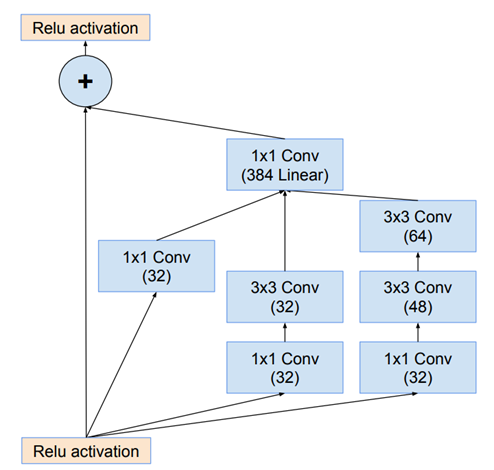

In [ ]:
def incResA(x, scale, name=None):

  branch0 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 32, 3, 1, 'same', True, name=name+'b1_2')

  branch2 = conv2d(x, 32, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 48, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, 64, 3, 1, 'same', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 384, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet B Block

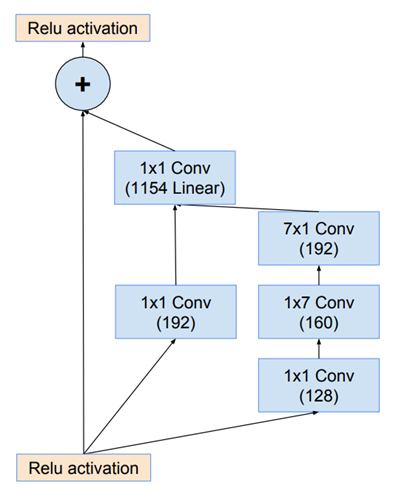

** _filt_exp_1x1 --> from 1154 chg to 1152 filters

In [ ]:
def incResB(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 128, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 160, [1,7], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 192, [7,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 1152, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Inception ResNet C Block

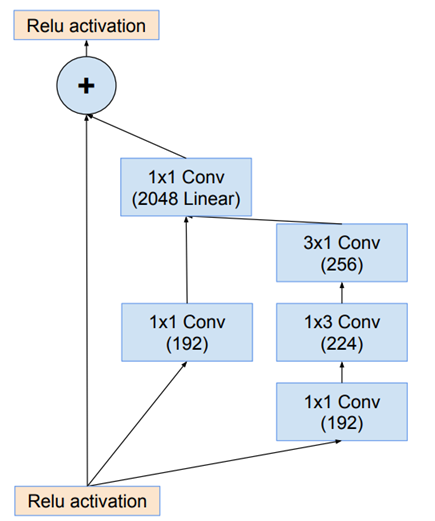

In [ ]:
def incResC(x, scale, name=None):

  branch0 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

  branch1 = conv2d(x, 192, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 224, [1,3], 1, 'same', True, name=name+'b1_2')
  branch1 = conv2d(branch1, 256, [3,1], 1, 'same', True, name=name+'b1_3')

  branches = [branch0, branch1]
  mixed = Concatenate(axis=3, name=name+'_concat')(branches)
  filt_exp_1x1 = conv2d(mixed, 2048, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

  final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                     output_shape=backend.int_shape(x)[1:],
                     arguments={'scale': scale},
                     name=name+'act_scaling')([x, filt_exp_1x1])

  return final_lay

## Reduction A Block

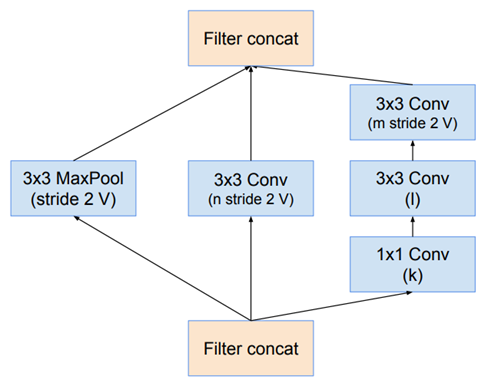

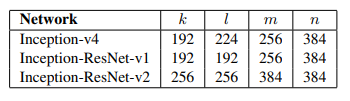

In [ ]:
def redA(x, name=None):

  n = 384; k = 256; l = 256; m = 384

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, n, 3, 2, 'valid', True, name=name+'b1')

  branch2 = conv2d(x, k, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, l, 3, 1, 'same', True, name=name+'b2_2')
  branch2 = conv2d(branch2, m, 3, 2, 'valid', True, name=name+'b2_3')

  branches = [branch0, branch1, branch2]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Reduction B Block

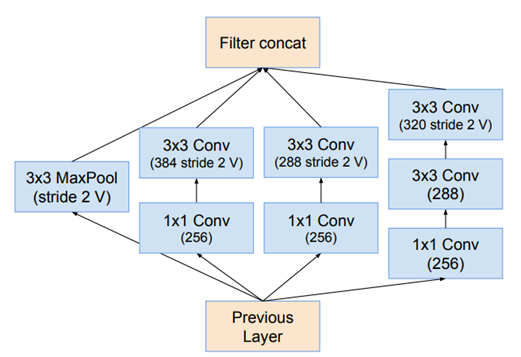

**layers b2_2, b3_2 and b3_3: # kernels --> 256

In [ ]:
def redB(x, name=None):

  branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

  branch1 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b1_1')
  branch1 = conv2d(branch1, 384, 3, 2, 'valid', True, name=name+'b1_2')

  branch2 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b2_1')
  branch2 = conv2d(branch2, 256, 3, 2, 'valid', True, name=name+'b2_2')

  branch3 = conv2d(x, 256, 1, 1, 'same', True, name=name+'b3_1')
  branch3 = conv2d(branch3, 256, 3, 1, 'same', True, name=name+'b3_2')
  branch3 = conv2d(branch3, 256, 3, 2, 'valid', True, name=name+'b3_3')

  branches = [branch0, branch1, branch2, branch3]
  final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

  return final_lay

## Stem Block

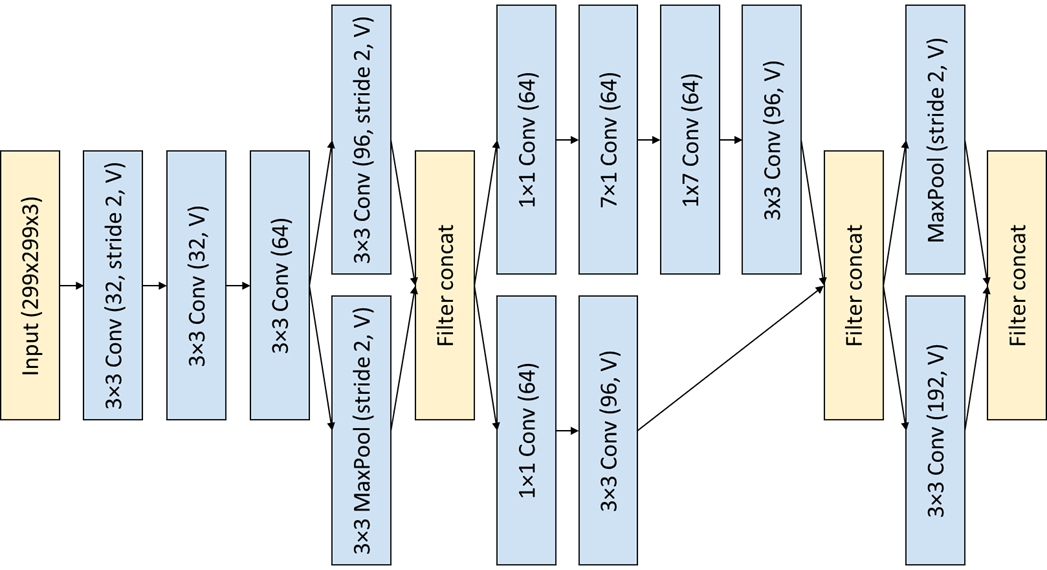

** layer stem_br_32 --> MaxPool, kernel_size = (3,3), stride = 1, 'valid'

In [ ]:
def stem(img_input):

  x = conv2d(img_input, 32, 3, 2, 'valid', True, name='conv1')
  x = conv2d(x, 32, 3, 1, 'valid', True, name='conv2')
  x = conv2d(x, 64, 3, 1, 'same', True, name='conv3')
  
  x_11 = MaxPooling2D((3,3), 2, 'valid', name='stem_br_11')(x)
  x_12 = conv2d(x, 96, 3, 2, 'valid', True, name='stem_br_12')
  
  x_1 = [x_11, x_12]
  x = Concatenate(axis=3, name='stem_filt_concat1')(x_1)
  
  x_21 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_211')
  x_21 = conv2d(x_21, 96, 3, 1, 'valid', True, name='stem_br_212')

  x_22 = conv2d(x, 64, 1, 1, 'same', True, name='stem_br_221')
  x_22 = conv2d(x_22, 64, [7,1], 1, 'same', True, name='stem_br_222')
  x_22 = conv2d(x_22, 64, [1,7], 1, 'same', True, name='stem_br_223')
  x_22 = conv2d(x_22, 96, 3, 1, 'valid', True, name='stem_br_224')

  x_2 = [x_21, x_22]
  x = Concatenate(axis=3, name='stem_filt_concat2')(x_2)
  
  x_31 = conv2d(x, 192, 3, 1, 'valid', True, name='stem_br_31')  # 51 51 192 
  x_32 = MaxPooling2D((3,3), 1, 'valid', name='stem_br_32')(x)   # 27 27 192  26 26 192

  x_3 = [x_31, x_32]
  x = Concatenate(axis=3, name='stem_filt_concat3')(x_3)
  
  return x

# Deep Learning Model - Inception ResNetV2 Model

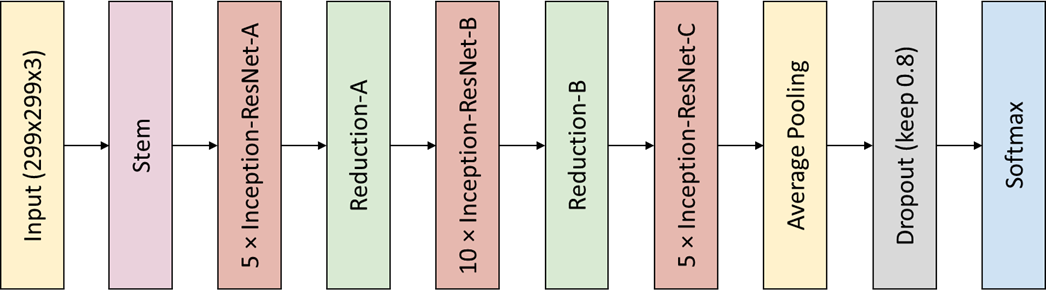

In [ ]:
tf.random.set_seed(42)
np.random.seed(128)

In [ ]:
# Base Model

incResA_count = 5
incResB_count = 10
incResC_count = 5

img_input = Input(shape=(SIZE, SIZE, 3))
x = stem(img_input)

for i in range(incResA_count):
  x = incResA(x, 0.15, name='incResA_'+str(i)+'_')
x = redA(x, name='redA_')

for i in range(incResB_count):
  x = incResB(x, 0.1, name='incResB_'+str(i)+'_')
x = redB(x, name='redB_')

for i in range(incResC_count):
  x = incResC(x, 0.2, name='incResC_'+str(i)+'_')

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(128, activation='relu')(x)   #64
# x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)   #0.8
x = Dense(n_classes, activation='softmax')(x)

# Build & Configure Model

Hyperparameter Setting (motivated by other researcher):

* learning rate of 0.045; decayed every two epochs using an
exponential rate of 0.94; reduce 0.1 if loss function does not improve ✅
* Weight initialisation with Gaussian ✅
* Early stopping patience, 10 epochs ✅
* Epochs = 300 ✅
* Mini-batch size = 32 ✅
* Model checkpoint - val_acc ✅
* Baseline - RMSProp with decay/rho of 0.9 and epsilon = 1.0, other  optimizer: Adam, SGD (momentum = 0.9), SGD (momentum = 0.9, Nesterov), GD (momentum = 0.9), AdaGrad ✅

In [ ]:
base_model = Model(img_input, x, name='inception_resnet_v2')

In [ ]:
base_model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9, epsilon=1.0),   # optimizer=Adam(learning_rate=0.045),#
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

## Early Stopping

In [ ]:
early = EarlyStopping(monitor="loss", 
                      mode="min", 
                      patience=10, restore_best_weights=True)

## Reduce LR

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

## LR Scheduler

In [ ]:
def scheduler(epoch, learning_rate):
  if epoch % 2 != 0 or epoch == 0:
    return learning_rate
  else:
    return learning_rate * tf.math.exp(-0.94)

In [ ]:
scheduler(0, 0.001)

0.001

In [ ]:
scheduler(2, 0.001).numpy()

0.00039062786

In [ ]:
lr_scheduler = LearningRateScheduler(scheduler)

## Model Checkpoint

In [ ]:
filepath = "base_model3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

## Callbacks

In [ ]:
# callbacks_list = [early, reduce_lr, lr_scheduler, checkpoint]
callbacks_list = [early, checkpoint, reduce_lr]

# Model Training

In [ ]:
# ttsplit 11; 
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=16), 
                         epochs=50,
                         steps_per_epoch=img_train.shape[0]//16,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.4145
Epoch 1: val_accuracy improved from -inf to 0.16008, saving model to base_model3.h5
126/126 [==============================] - 50s 223ms/step - loss: 1.5019 - accuracy: 0.4145 - val_loss: 1.7942 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 1.2657 - accuracy: 0.5157
Epoch 2: val_accuracy improved from 0.16008 to 0.28656, saving model to base_model3.h5
126/126 [==============================] - 26s 209ms/step - loss: 1.2657 - accuracy: 0.5157 - val_loss: 1.7803 - val_accuracy: 0.2866 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.5526
Epoch 3: val_accuracy improved from 0.28656 to 0.35375, saving model to base_model3.h5
126/126 [==============================] - 27s 216ms/step - loss: 1.1949 - accuracy: 0.5526 - val_loss: 1.6956 - val_accuracy: 0.3538 - lr: 0.0010
Epoch 4/50
12

KeyboardInterrupt: ignored

In [ ]:
# include reduce_lr --> check if the convergence rate increase
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=100,
                         steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.6407 - accuracy: 0.3831
Epoch 1: val_accuracy improved from -inf to 0.23518, saving model to base_model3.h5
63/63 [==============================] - 66s 460ms/step - loss: 1.6407 - accuracy: 0.3831 - val_loss: 1.8023 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.3463 - accuracy: 0.4967
Epoch 2: val_accuracy improved from 0.23518 to 0.30040, saving model to base_model3.h5
63/63 [==============================] - 24s 379ms/step - loss: 1.3463 - accuracy: 0.4967 - val_loss: 1.7927 - val_accuracy: 0.3004 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.5359
Epoch 3: val_accuracy did not improve from 0.30040
63/63 [==============================] - 23s 366ms/step - loss: 1.2651 - accuracy: 0.5359 - val_loss: 1.7967 - val_accuracy: 0.2510 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - ETA: 

In [ ]:
# alter data aug
history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
                         epochs=20,
                         #steps_per_epoch=img_train.shape[0]//32,
                         validation_data=(img_test, label_encoded_test))
                         #callbacks=callbacks_list)

Epoch 1/20
64/64 [==============================] - 43s 402ms/step - loss: 1.5446 - accuracy: 0.4082 - val_loss: 1.7834 - val_accuracy: 0.1601
Epoch 2/20
64/64 [==============================] - 24s 381ms/step - loss: 1.2869 - accuracy: 0.5186 - val_loss: 1.7994 - val_accuracy: 0.1601
Epoch 3/20
64/64 [==============================] - 25s 389ms/step - loss: 1.2080 - accuracy: 0.5562 - val_loss: 1.7949 - val_accuracy: 0.1621
Epoch 4/20
64/64 [==============================] - 24s 371ms/step - loss: 1.1275 - accuracy: 0.6007 - val_loss: 1.7628 - val_accuracy: 0.2352
Epoch 5/20
64/64 [==============================] - 24s 380ms/step - loss: 1.0923 - accuracy: 0.6002 - val_loss: 1.7502 - val_accuracy: 0.2925
Epoch 6/20
64/64 [==============================] - 24s 376ms/step - loss: 1.0404 - accuracy: 0.6239 - val_loss: 1.6482 - val_accuracy: 0.3439
Epoch 7/20
64/64 [==============================] - 24s 374ms/step - loss: 0.9951 - accuracy: 0.6343 - val_loss: 1.5175 - val_accuracy: 0.3676

In [ ]:
# without datagen
# history = base_model.fit(datagen.flow(img_train, label_encoded_train, batch_size=32), 
#                          epochs=20,
#                          steps_per_epoch=img_train.shape[0]//32,
#                          validation_data=(img_test, label_encoded_test),
#                          callbacks=callbacks_list)

history = base_model.fit(img_train, label_encoded_train, batch_size=8, 
                         epochs=50,
                         steps_per_epoch=img_train.shape[0]//8,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/50
252/252 [==============================] - ETA: 0s - loss: 1.6167 - accuracy: 0.3844
Epoch 1: val_accuracy improved from -inf to 0.22530, saving model to base_model3.h5
252/252 [==============================] - 63s 160ms/step - loss: 1.6167 - accuracy: 0.3844 - val_loss: 1.8024 - val_accuracy: 0.2253 - lr: 0.0010
Epoch 2/50
252/252 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.4948
Epoch 2: val_accuracy improved from 0.22530 to 0.28656, saving model to base_model3.h5
252/252 [==============================] - 37s 146ms/step - loss: 1.3264 - accuracy: 0.4948 - val_loss: 1.6992 - val_accuracy: 0.2866 - lr: 0.0010
Epoch 3/50
252/252 [==============================] - ETA: 0s - loss: 1.2451 - accuracy: 0.5266
Epoch 3: val_accuracy improved from 0.28656 to 0.52767, saving model to base_model3.h5
252/252 [==============================] - 37s 148ms/step - loss: 1.2451 - accuracy: 0.5266 - val_loss: 1.2579 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 4/50
25

In [ ]:
history = base_model.fit(img_train, label_encoded_train, batch_size=16, 
                         epochs=20,
                         steps_per_epoch=img_train.shape[0]//16,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9345
Epoch 1: val_accuracy did not improve from 0.83597
126/126 [==============================] - 27s 214ms/step - loss: 0.2733 - accuracy: 0.9345 - val_loss: 0.5392 - val_accuracy: 0.8281 - lr: 1.5625e-05
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.9272
Epoch 2: val_accuracy did not improve from 0.83597
126/126 [==============================] - 26s 211ms/step - loss: 0.2874 - accuracy: 0.9272 - val_loss: 0.5427 - val_accuracy: 0.8320 - lr: 1.5625e-05
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.9142
Epoch 3: val_accuracy did not improve from 0.83597
126/126 [==============================] - 27s 213ms/step - loss: 0.2947 - accuracy: 0.9142 - val_loss: 0.5377 - val_accuracy: 0.8261 - lr: 1.5625e-05
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.9302
Epoch 4: v

In [ ]:
history = base_model.fit(img_train, label_encoded_train, batch_size=16, 
                         epochs=50,
                         steps_per_epoch=img_train.shape[0]//16,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 1.5051 - accuracy: 0.4221
Epoch 1: val_accuracy improved from -inf to 0.16008, saving model to base_model3.h5
126/126 [==============================] - 49s 247ms/step - loss: 1.5051 - accuracy: 0.4221 - val_loss: 1.8091 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 1.2490 - accuracy: 0.5451
Epoch 2: val_accuracy improved from 0.16008 to 0.33992, saving model to base_model3.h5
126/126 [==============================] - 28s 224ms/step - loss: 1.2490 - accuracy: 0.5451 - val_loss: 1.7498 - val_accuracy: 0.3399 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 1.1240 - accuracy: 0.5975
Epoch 3: val_accuracy improved from 0.33992 to 0.36759, saving model to base_model3.h5
126/126 [==============================] - 28s 219ms/step - loss: 1.1240 - accuracy: 0.5975 - val_loss: 1.7171 - val_accuracy: 0.3676 - lr: 0.0010
Epoch 4/50
12

In [ ]:
history = base_model.fit(img_train, label_encoded_train, batch_size=16, 
                         epochs=30,
                         steps_per_epoch=img_train.shape[0]//16,
                         validation_data=(img_test, label_encoded_test),
                         callbacks=callbacks_list)

Epoch 1/30
126/126 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9524
Epoch 1: val_accuracy did not improve from 0.81225
126/126 [==============================] - 28s 219ms/step - loss: 0.2371 - accuracy: 0.9524 - val_loss: 0.5828 - val_accuracy: 0.8024 - lr: 2.5000e-04
Epoch 2/30
126/126 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9426
Epoch 2: val_accuracy did not improve from 0.81225
126/126 [==============================] - 27s 217ms/step - loss: 0.2466 - accuracy: 0.9426 - val_loss: 0.5600 - val_accuracy: 0.8123 - lr: 2.5000e-04
Epoch 3/30
126/126 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9411
Epoch 3: val_accuracy did not improve from 0.81225
126/126 [==============================] - 26s 208ms/step - loss: 0.2417 - accuracy: 0.9411 - val_loss: 0.5647 - val_accuracy: 0.8103 - lr: 2.5000e-04
Epoch 4/30
126/126 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9561
Epoch 4: v

# Custom Model Class

## Model Class

In [14]:
class customInceptionResnetv2:

  def __init__(self, x_train, y_train, x_test, y_test, size,
               incResA_count, incResB_count, incResC_count, optimizer,
               modelFilePath, historyFilePath,
               epochs=150, batch_size=16,
               seed_value=128, tf_seed=42, np_seed=128): 

    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)
    
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    self.size = size

    self.modelFilePath = modelFilePath
    self.historyFilePath = historyFilePath

    self.incResA_count = incResA_count
    self.incResB_count = incResB_count
    self.incResC_count = incResC_count
    self.optimizer = optimizer

    self.epochs = epochs
    self.batch_size = batch_size

  def conv2d(self, x, filters, kernel_size, strides=1, pad='same', act=True, name=None):
    x = Conv2D(filters=filters, kernel_size=kernel_size,
              strides=strides, padding=pad,
              data_format='channels_last', use_bias=False,
              name=name+'conv2d')(x)
    x = BatchNormalization(axis=3, scale=False, name=name+'conv2d_bn')(x)
    if act:
      x = Activation('relu', name=name+'conv2d_act')(x)
    return x
  
  def incResA(self, x, scale, name=None):
    branch0 = self.conv2d(x, 32, 1, 1, 'same', True, name=name+'b0')

    branch1 = self.conv2d(x, 32, 1, 1, 'same', True, name=name+'b1_1')
    branch1 = self.conv2d(branch1, 32, 3, 1, 'same', True, name=name+'b1_2')

    branch2 = self.conv2d(x, 32, 1, 1, 'same', True, name=name+'b2_1')
    branch2 = self.conv2d(branch2, 48, 3, 1, 'same', True, name=name+'b2_2')
    branch2 = self.conv2d(branch2, 64, 3, 1, 'same', True, name=name+'b2_3')

    branches = [branch0, branch1, branch2]
    mixed = Concatenate(axis=3, name=name+'_concat')(branches)
    filt_exp_1x1 = self.conv2d(mixed, 384, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

    final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])

    return final_lay
  
  def incResB(self, x, scale, name=None):
    branch0 = self.conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

    branch1 = self.conv2d(x, 128, 1, 1, 'same', True, name=name+'b1_1')
    branch1 = self.conv2d(branch1, 160, [1,7], 1, 'same', True, name=name+'b1_2')
    branch1 = self.conv2d(branch1, 192, [7,1], 1, 'same', True, name=name+'b1_3')

    branches = [branch0, branch1]
    mixed = Concatenate(axis=3, name=name+'_concat')(branches)
    filt_exp_1x1 = self.conv2d(mixed, 1152, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

    final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])

    return final_lay
  
  def incResC(self, x, scale, name=None):
    branch0 = self.conv2d(x, 192, 1, 1, 'same', True, name=name+'b0')

    branch1 = self.conv2d(x, 192, 1, 1, 'same', True, name=name+'b1_1')
    branch1 = self.conv2d(branch1, 224, [1,3], 1, 'same', True, name=name+'b1_2')
    branch1 = self.conv2d(branch1, 256, [3,1], 1, 'same', True, name=name+'b1_3')

    branches = [branch0, branch1]
    mixed = Concatenate(axis=3, name=name+'_concat')(branches)
    filt_exp_1x1 = self.conv2d(mixed, 2048, 1, 1, 'same', False, name=name+'_filt_exp_1x1')

    final_lay = Lambda(lambda inputs, scale: inputs[0]+inputs[1]*scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])

    return final_lay
  
  def redA(self, x, name=None):
    n = 384; k = 256; l = 256; m = 384

    branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

    branch1 = self.conv2d(x, n, 3, 2, 'valid', True, name=name+'b1')

    branch2 = self.conv2d(x, k, 1, 1, 'same', True, name=name+'b2_1')
    branch2 = self.conv2d(branch2, l, 3, 1, 'same', True, name=name+'b2_2')
    branch2 = self.conv2d(branch2, m, 3, 2, 'valid', True, name=name+'b2_3')

    branches = [branch0, branch1, branch2]
    final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

    return final_lay
  
  def redB(self, x, name=None):
    branch0 = MaxPooling2D((3,3), 2, 'valid', name=name+'b0')(x)

    branch1 = self.conv2d(x, 256, 1, 1, 'same', True, name=name+'b1_1')
    branch1 = self.conv2d(branch1, 384, 3, 2, 'valid', True, name=name+'b1_2')

    branch2 = self.conv2d(x, 256, 1, 1, 'same', True, name=name+'b2_1')
    branch2 = self.conv2d(branch2, 256, 3, 2, 'valid', True, name=name+'b2_2')

    branch3 = self.conv2d(x, 256, 1, 1, 'same', True, name=name+'b3_1')
    branch3 = self.conv2d(branch3, 256, 3, 1, 'same', True, name=name+'b3_2')
    branch3 = self.conv2d(branch3, 256, 3, 2, 'valid', True, name=name+'b3_3')

    branches = [branch0, branch1, branch2, branch3]
    final_lay = Concatenate(axis=3, name=name+'_filt_concat')(branches)

    return final_lay
  
  def stem(self, img_input):
    x = self.conv2d(img_input, 32, 3, 2, 'valid', True, name='conv1')
    x = self.conv2d(x, 32, 3, 1, 'valid', True, name='conv2')
    x = self.conv2d(x, 64, 3, 1, 'same', True, name='conv3')
    
    x_11 = MaxPooling2D((3,3), 2, 'valid', name='stem_br_11')(x)
    x_12 = self.conv2d(x, 96, 3, 2, 'valid', True, name='stem_br_12')
    
    x_1 = [x_11, x_12]
    x = Concatenate(axis=3, name='stem_filt_concat1')(x_1)
    
    x_21 = self.conv2d(x, 64, 1, 1, 'same', True, name='stem_br_211')
    x_21 = self.conv2d(x_21, 96, 3, 1, 'valid', True, name='stem_br_212')

    x_22 = self.conv2d(x, 64, 1, 1, 'same', True, name='stem_br_221')
    x_22 = self.conv2d(x_22, 64, [7,1], 1, 'same', True, name='stem_br_222')
    x_22 = self.conv2d(x_22, 64, [1,7], 1, 'same', True, name='stem_br_223')
    x_22 = self.conv2d(x_22, 96, 3, 1, 'valid', True, name='stem_br_224')

    x_2 = [x_21, x_22]
    x = Concatenate(axis=3, name='stem_filt_concat2')(x_2)
    
    x_31 = self.conv2d(x, 192, 3, 1, 'valid', True, name='stem_br_31')  # 51 51 192 
    x_32 = MaxPooling2D((3,3), 1, 'valid', name='stem_br_32')(x)   # 27 27 192  26 26 192

    x_3 = [x_31, x_32]
    x = Concatenate(axis=3, name='stem_filt_concat3')(x_3)
    
    return x

  def constructModel(self):
    img_input = Input(shape=(self.size, self.size, 3))
    x = self.stem(img_input)

    for i in range(self.incResA_count):
      x = self.incResA(x, 0.15, name='incResA_'+str(i)+'_')
    x = self.redA(x, name='redA_')

    for i in range(self.incResB_count):
      x = self.incResB(x, 0.1, name='incResB_'+str(i)+'_')
    x = self.redB(x, name='redB_')

    for i in range(self.incResC_count):
      x = self.incResC(x, 0.2, name='incResC_'+str(i)+'_')

    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dense(128, activation='relu')(x)   
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation='softmax')(x)

    return img_input, x

  def create_model(self):
    img_input, x = self.constructModel()
    model = Model(img_input, x, name='inception_resnet_v2')
    model.compile(optimizer=self.optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

  def train_model(self):
    model = self.create_model()

    early = EarlyStopping(monitor="loss", mode="min", 
                          patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    checkpoint = ModelCheckpoint(self.modelFilePath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='max')
    callbacks_list = [early, checkpoint, reduce_lr]

    history = model.fit(self.x_train, self.y_train, batch_size=self.batch_size, 
                        epochs=self.epochs,
                        steps_per_epoch=self.x_train.shape[0]//self.batch_size,
                        validation_data=(self.x_test, self.y_test),
                        callbacks=callbacks_list)
    with open(self.historyFilePath, 'wb') as f:
      pickle.dump(history.history, f)
    

## Model Training

### Optimizer

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (RMSprop)
optimizer = RMSprop(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_RMSprop_weight.h5", "baseline_5_10_5_RMSprop_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 2.2914 - accuracy: 0.3447
Epoch 1: val_accuracy improved from -inf to 0.16403, saving model to baseline_5_10_5_RMSprop_weight.h5
126/126 [==============================] - 43s 221ms/step - loss: 2.2914 - accuracy: 0.3447 - val_loss: 246.0457 - val_accuracy: 0.1640 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.5071 - accuracy: 0.4130
Epoch 2: val_accuracy improved from 0.16403 to 0.35771, saving model to baseline_5_10_5_RMSprop_weight.h5
126/126 [==============================] - 26s 204ms/step - loss: 1.5071 - accuracy: 0.4130 - val_loss: 1.8914 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3796 - accuracy: 0.4798
Epoch 3: val_accuracy did not improve from 0.35771
126/126 [==============================] - 26s 207ms/step - loss: 1.3796 - accuracy: 0.4798 - val_loss: 61.5024 - val_accuracy: 0.2055 - lr: 0.0010
Epoch

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adam_weight.h5", "baseline_5_10_5_Adam_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.9967 - accuracy: 0.4077
Epoch 1: val_accuracy improved from -inf to 0.20356, saving model to baseline_5_10_5_Adam_weight.h5
126/126 [==============================] - 50s 216ms/step - loss: 1.9967 - accuracy: 0.4077 - val_loss: 1.7849 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.4678
Epoch 2: val_accuracy improved from 0.20356 to 0.23913, saving model to baseline_5_10_5_Adam_weight.h5
126/126 [==============================] - 26s 199ms/step - loss: 1.3831 - accuracy: 0.4678 - val_loss: 2.0006 - val_accuracy: 0.2391 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3177 - accuracy: 0.4988
Epoch 3: val_accuracy improved from 0.23913 to 0.31225, saving model to baseline_5_10_5_Adam_weight.h5
126/126 [==============================] - 26s 208ms/step - loss: 1.3177 - accuracy: 0.4988 - val_loss: 2.262

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (SGD)
optimizer = SGD(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_SGD_weight.h5", "baseline_5_10_5_SGD_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.6249 - accuracy: 0.3785
Epoch 1: val_accuracy improved from -inf to 0.18577, saving model to baseline_5_10_5_SGD_weight.h5
126/126 [==============================] - 48s 213ms/step - loss: 1.6249 - accuracy: 0.3785 - val_loss: 1.7916 - val_accuracy: 0.1858 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.3016 - accuracy: 0.5177
Epoch 2: val_accuracy improved from 0.18577 to 0.29644, saving model to baseline_5_10_5_SGD_weight.h5
126/126 [==============================] - 32s 244ms/step - loss: 1.3016 - accuracy: 0.5177 - val_loss: 1.7530 - val_accuracy: 0.2964 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.2091 - accuracy: 0.5481
Epoch 3: val_accuracy improved from 0.29644 to 0.34980, saving model to baseline_5_10_5_SGD_weight.h5
126/126 [==============================] - 28s 220ms/step - loss: 1.2091 - accuracy: 0.5481 - val_loss: 1.7160 -

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (SGD + Nesterov)
optimizer = SGD(learning_rate=0.001, nesterov=True)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_SGD_Nest_weight.h5", "baseline_5_10_5_SGD_Nest_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.6213 - accuracy: 0.3879
Epoch 1: val_accuracy improved from -inf to 0.11660, saving model to baseline_5_10_5_SGD_Nest_weight.h5
126/126 [==============================] - 46s 207ms/step - loss: 1.6213 - accuracy: 0.3879 - val_loss: 1.8006 - val_accuracy: 0.1166 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.2952 - accuracy: 0.5202
Epoch 2: val_accuracy improved from 0.11660 to 0.37747, saving model to baseline_5_10_5_SGD_Nest_weight.h5
126/126 [==============================] - 26s 197ms/step - loss: 1.2952 - accuracy: 0.5202 - val_loss: 1.7391 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.1913 - accuracy: 0.5646
Epoch 3: val_accuracy did not improve from 0.37747
126/126 [==============================] - 23s 186ms/step - loss: 1.1913 - accuracy: 0.5646 - val_loss: 1.6856 - val_accuracy: 0.3340 - lr: 0.0010
Epoch 

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adagrad)
optimizer = Adagrad(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adagrad_weight.h5", "baseline_5_10_5_Adagrad_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.5072 - accuracy: 0.4449
Epoch 1: val_accuracy improved from -inf to 0.19170, saving model to baseline_5_10_5_SGD_Adagrad_weight.h5
126/126 [==============================] - 41s 214ms/step - loss: 1.5072 - accuracy: 0.4449 - val_loss: 1.7920 - val_accuracy: 0.1917 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.5706
Epoch 2: val_accuracy improved from 0.19170 to 0.24506, saving model to baseline_5_10_5_SGD_Adagrad_weight.h5
126/126 [==============================] - 25s 203ms/step - loss: 1.1735 - accuracy: 0.5706 - val_loss: 1.7559 - val_accuracy: 0.2451 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.6135
Epoch 3: val_accuracy improved from 0.24506 to 0.33794, saving model to baseline_5_10_5_SGD_Adagrad_weight.h5
126/126 [==============================] - 26s 210ms/step - loss: 1.0540 - accuracy: 0.6

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adadelta)
optimizer = Adadelta(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adadelta_weight.h5", "baseline_5_10_5_Adadelta_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 2.5980 - accuracy: 0.1949
Epoch 1: val_accuracy improved from -inf to 0.23518, saving model to baseline_5_10_5_Adadelta_weight.h5
126/126 [==============================] - 37s 219ms/step - loss: 2.5980 - accuracy: 0.1949 - val_loss: 1.8150 - val_accuracy: 0.2352 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.8894 - accuracy: 0.2913
Epoch 2: val_accuracy improved from 0.23518 to 0.23913, saving model to baseline_5_10_5_Adadelta_weight.h5
126/126 [==============================] - 26s 207ms/step - loss: 1.8894 - accuracy: 0.2913 - val_loss: 1.8046 - val_accuracy: 0.2391 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.6865 - accuracy: 0.3526
Epoch 3: val_accuracy improved from 0.23913 to 0.31621, saving model to baseline_5_10_5_Adadelta_weight.h5
126/126 [==============================] - 26s 206ms/step - loss: 1.6865 - accuracy: 0.3526 - val

### Network Depth

with Adam optimizer

In [ ]:
# Inception-ResNetV2-4,9,4 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                4, 9, 4, optimizer,
                                "InceptionResNetV2_4_9_4_Adam_weight.h5", "InceptionResNetV2_4_9_4_Adam_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.7661 - accuracy: 0.4142
Epoch 1: val_accuracy improved from -inf to 0.18972, saving model to InceptionResNetV2_4_9_4_Adam_weight.h5
126/126 [==============================] - 61s 210ms/step - loss: 1.7661 - accuracy: 0.4142 - val_loss: 2.6949 - val_accuracy: 0.1897 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.4221 - accuracy: 0.4589
Epoch 2: val_accuracy improved from 0.18972 to 0.25889, saving model to InceptionResNetV2_4_9_4_Adam_weight.h5
126/126 [==============================] - 25s 185ms/step - loss: 1.4221 - accuracy: 0.4589 - val_loss: 1.8167 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.5012
Epoch 3: val_accuracy improved from 0.25889 to 0.29644, saving model to InceptionResNetV2_4_9_4_Adam_weight.h5
126/126 [==============================] - 25s 195ms/step - loss: 1.3117 - accuracy: 

In [ ]:
# Inception-ResNetV2-3,8,3 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                3, 8, 3, optimizer,
                                "InceptionResNetV2_3_8_3_Adam_weight.h5", "InceptionResNetV2_3_8_3_Adam_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.9240 - accuracy: 0.3968
Epoch 1: val_accuracy improved from -inf to 0.30040, saving model to InceptionResNetV2_3_8_3_Adam_weight.h5
126/126 [==============================] - 29s 179ms/step - loss: 1.9240 - accuracy: 0.3968 - val_loss: 1.8571 - val_accuracy: 0.3004 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.4147 - accuracy: 0.4698
Epoch 2: val_accuracy improved from 0.30040 to 0.36957, saving model to InceptionResNetV2_3_8_3_Adam_weight.h5
126/126 [==============================] - 22s 172ms/step - loss: 1.4147 - accuracy: 0.4698 - val_loss: 1.8857 - val_accuracy: 0.3696 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.5007
Epoch 3: val_accuracy did not improve from 0.36957
126/126 [==============================] - 21s 169ms/step - loss: 1.3685 - accuracy: 0.5007 - val_loss: 1.7667 - val_accuracy: 0.2668 - lr: 0.001

In [15]:
# Inception-ResNetV2-2,7,2 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                2, 7, 2, optimizer,
                                "InceptionResNetV2_2_7_2_Adam_weight.h5", "InceptionResNetV2_2_7_2_Adam_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.7824 - accuracy: 0.4082
Epoch 1: val_accuracy improved from -inf to 0.22530, saving model to InceptionResNetV2_2_7_2_Adam_weight.h5
126/126 [==============================] - 39s 158ms/step - loss: 1.7824 - accuracy: 0.4082 - val_loss: 1.9670 - val_accuracy: 0.2253 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.4628
Epoch 2: val_accuracy did not improve from 0.22530
126/126 [==============================] - 18s 136ms/step - loss: 1.4177 - accuracy: 0.4628 - val_loss: 2.2904 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3410 - accuracy: 0.4958
Epoch 3: val_accuracy improved from 0.22530 to 0.27668, saving model to InceptionResNetV2_2_7_2_Adam_weight.h5
126/126 [==============================] - 18s 144ms/step - loss: 1.3410 - accuracy: 0.4958 - val_loss: 1.8312 - val_accuracy: 0.2767 - lr: 0.001

In [29]:
# Inception-ResNetV2-1,6,1 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                1, 6, 1, optimizer,
                                "InceptionResNetV2_1_6_1_Adam_weight.h5", "InceptionResNetV2_1_6_1_Adam_history")
model.train_model()

Epoch 1/150
126/126 [==============================] - ETA: 0s - loss: 1.6964 - accuracy: 0.4102
Epoch 1: val_accuracy improved from -inf to 0.22530, saving model to InceptionResNetV2_1_6_1_Adam_weight.h5
126/126 [==============================] - 22s 134ms/step - loss: 1.6964 - accuracy: 0.4102 - val_loss: 1.9991 - val_accuracy: 0.2253 - lr: 0.0010
Epoch 2/150
126/126 [==============================] - ETA: 0s - loss: 1.3828 - accuracy: 0.4673
Epoch 2: val_accuracy improved from 0.22530 to 0.32213, saving model to InceptionResNetV2_1_6_1_Adam_weight.h5
126/126 [==============================] - 16s 126ms/step - loss: 1.3828 - accuracy: 0.4673 - val_loss: 2.1944 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 3/150
126/126 [==============================] - ETA: 0s - loss: 1.3216 - accuracy: 0.4893
Epoch 3: val_accuracy did not improve from 0.32213
126/126 [==============================] - 15s 120ms/step - loss: 1.3216 - accuracy: 0.4893 - val_loss: 2.0798 - val_accuracy: 0.2688 - lr: 0.001

# Load Model & History

## Load Training History

In [27]:
def plotTrainingCurves(filepath):
  history = pickle.load(open(filepath, "rb"))

  plt.rcParams.update({'font.size': 12})
  plt_1 = plt.figure(figsize=(6, 4))

  plt.plot(history['accuracy'], label="train acc")
  plt.plot(history['val_accuracy'], label="test acc")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  # plt.title("Accuracy Curve")
  plt.legend()
  plt.grid()
  plt.show()

  plt_1 = plt.figure(figsize=(6, 4))
  plt.plot(history['loss'], label="train loss")
  plt.plot(history['val_loss'], label="test loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # plt.title("Loss Curve")
  plt.legend()
  plt.grid()
  plt.show()

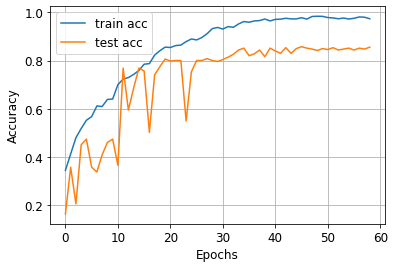

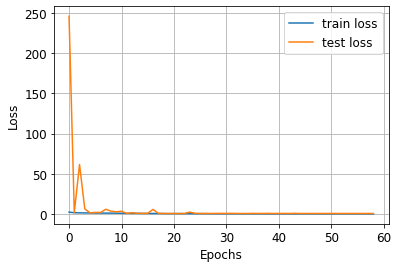

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_RMSprop_history')

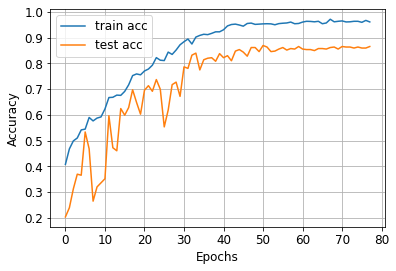

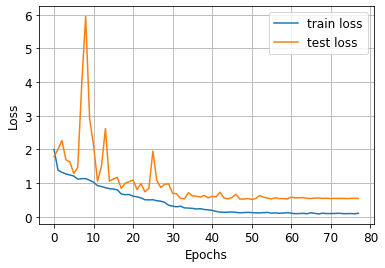

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_Adam_history')

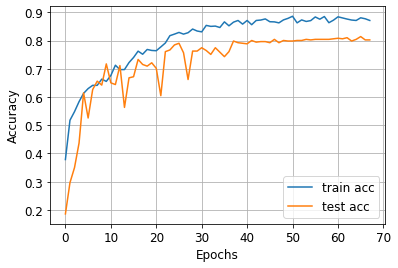

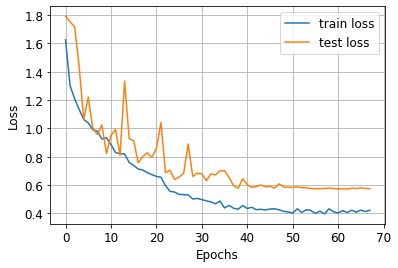

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_SGD_history')

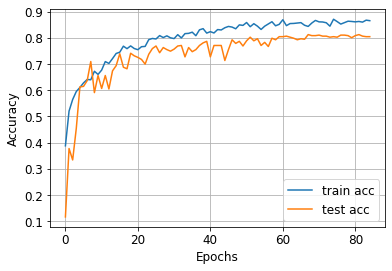

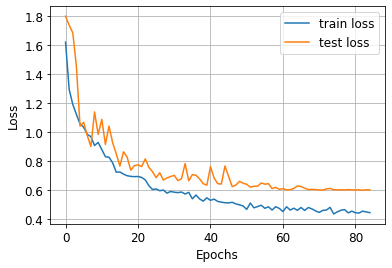

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_SGD_Nest_history')

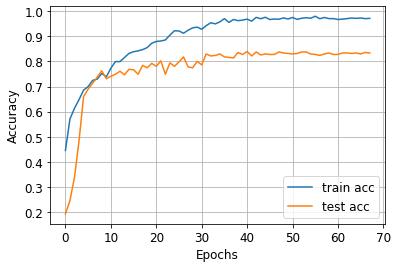

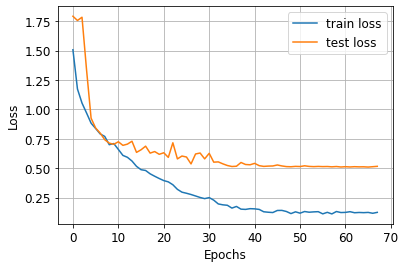

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_Adagrad_history')

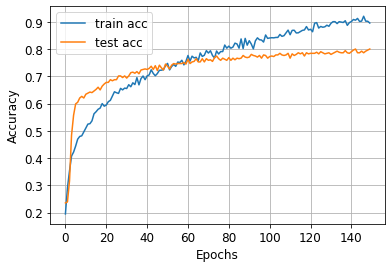

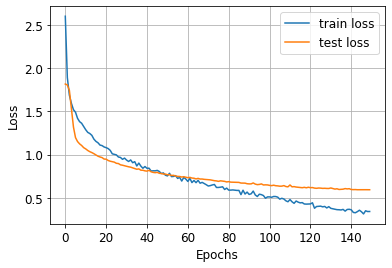

In [ ]:
plotTrainingCurves('/content/baseline_5_10_5_Adadelta_history')

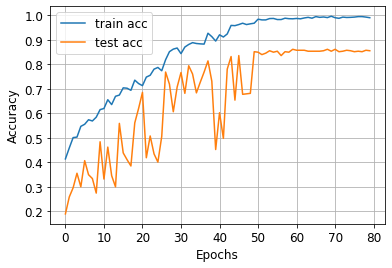

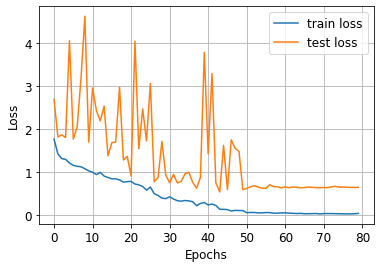

In [ ]:
plotTrainingCurves('/content/InceptionResNetV2_4_9_4_Adam_history')

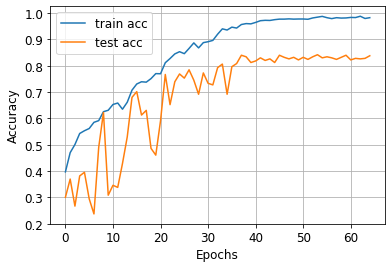

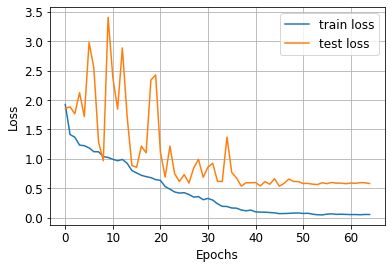

In [ ]:
plotTrainingCurves('/content/InceptionResNetV2_3_8_3_Adam_history')

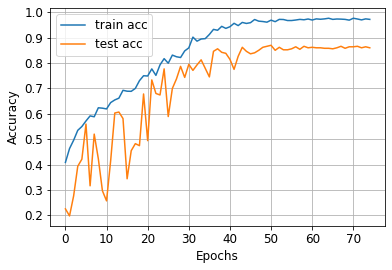

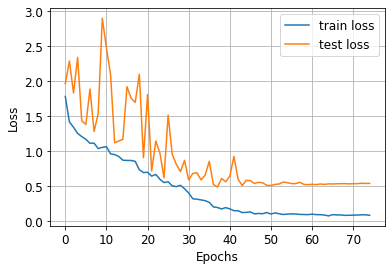

In [28]:
plotTrainingCurves('/content/InceptionResNetV2_2_7_2_Adam_history')

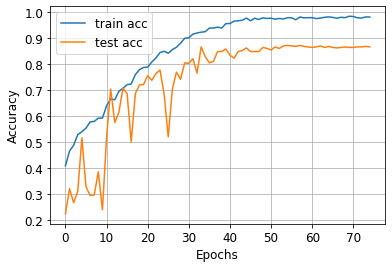

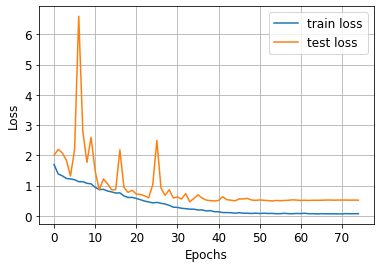

In [30]:
plotTrainingCurves('/content/InceptionResNetV2_1_6_1_Adam_history')

## Load Model

## Load Model Weights

In [ ]:
!ssh-keygen -t rsa -b 4096

In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

In [ ]:
!cat /root/.ssh/id_rsa.pub

In [ ]:
!ssh -T git@github.com

In [ ]:
!git lfs clone git@github.com:jxin11/waste-image-classification.git

### Optimizers

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (RMSprop)
optimizer = RMSprop(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_RMSprop_weight.h5", "baseline_5_10_5_RMSprop_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_RMSprop_weight.h5')

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adam_weight.h5", "baseline_5_10_5_Adam_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_Adam_weight.h5')

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (SGD)
optimizer = SGD(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_SGD_weight.h5", "baseline_5_10_5_SGD_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_SGD_weight.h5')

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (SGD + Nesterov)
optimizer = SGD(learning_rate=0.001, nesterov=True)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_SGD_Nest_weight.h5", "baseline_5_10_5_SGD_Nest_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_SGD_Nest_weight.h5')

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adagrad)
optimizer = Adagrad(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adagrad_weight.h5", "baseline_5_10_5_Adagrad_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_Adagrad_weight.h5')

In [ ]:
# Baseline Model: Inception-ResNetV2-5,10,5 (Adadelta)
optimizer = Adadelta(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                5, 10, 5, optimizer,
                                "baseline_5_10_5_Adadelta_weight.h5", "baseline_5_10_5_Adadelta_history")
model1 = model.create_model()
model1.load_weights('/content/baseline_5_10_5_Adadelta_weight.h5')

### Network Depth

In [ ]:
# Inception-ResNetV2-4,9,4 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                4, 9, 4, optimizer,
                                "InceptionResNetV2_4_9_4_Adam_weight.h5", "InceptionResNetV2_4_9_4_Adam_history")
model1 = model.create_model()
model1.load_weights('/content/InceptionResNetV2_4_9_4_Adam_weight.h5')
print(model1.count_params())

26501286


In [ ]:
# Inception-ResNetV2-3,8,3 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                3, 8, 3, optimizer,
                                "InceptionResNetV2_3_8_3_Adam_weight.h5", "InceptionResNetV2_3_8_3_Adam_history")
model1 = model.create_model()
model1.load_weights('/content/InceptionResNetV2_3_8_3_Adam_weight.h5')
print(model1.count_params())

23174102


In [16]:
# Inception-ResNetV2-2,7,2 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                2, 7, 2, optimizer,
                                "InceptionResNetV2_2_7_2_Adam_weight.h5", "InceptionResNetV2_2_7_2_Adam_history")
model1 = model.create_model()
model1.load_weights('/content/InceptionResNetV2_2_7_2_Adam_weight.h5')
print(model1.count_params())

19846918


In [31]:
# Inception-ResNetV2-1,6,1 (Adam)
optimizer = Adam(learning_rate=0.001)
model = customInceptionResnetv2(img_train, label_encoded_train, img_test, label_encoded_test, SIZE,
                                1, 6, 1, optimizer,
                                "InceptionResNetV2_1_6_1_Adam_weight.h5", "InceptionResNetV2_1_6_1_Adam_history")
model1 = model.create_model()
model1.load_weights('/content/InceptionResNetV2_1_6_1_Adam_weight.h5')
print(model1.count_params())

16519734


# Evaluation

## Accuracy

In [32]:
# Training Acc

pred = [i.argmax() for i in model1.predict(img_train)]
pred = le.inverse_transform(pred)

print("Training Acc: ", accuracy_score(label_train, pred))

Training Acc:  0.9995051954477981


Why the training accuracy computed is different from the value obtained during training?

The usage of dropout. Dropout is only enabled during training, but not during evaluation or prediction. Moreover, the training accuracy that is displayed in the bar shows the averaged accuracy over the training epoch, averaged over the batch accuracies calculated after each batch.

Ref: https://stackoverflow.com/questions/56991909/how-is-the-keras-accuracy-showed-in-progress-bar-calculated-from-which-inputs-i

In [33]:
# Testing Acc

pred = [i.argmax() for i in model1.predict(img_test)]
pred = le.inverse_transform(pred)

print("Testing Acc: ", accuracy_score(label_test, pred))

Testing Acc:  0.8735177865612648


Performance of baseline model Inception-ResNetV2-5,10,5 with different optimizers, given the same hyperparameter setting.

No | Optmizers | Train Acc | Test Acc
-- | --------- | --------- | --------
1 | RMSProp | 99.7526 | 85.7708
2 | Adam | 99.9505 | 86.9565
3 | SGD | 95.5962 | 81.4229
4 | SGD + Nesterov | 93.7160 | 81.2253
5 | Adagrad | 99.7031 | 83.9921
6 | Adadelta | 97.9713 | 80.0395


Performance of baseline model Inception-ResNetV2 with Adam optimizer but with different network depth.

No | Model | Train Acc | Test Acc
-- | --------- | --------- | --------
1 | Inception-ResNetV2-5,10,5 | 99.9505 | 86.9565
2 | Inception-ResNetV2-4,9,4 | 99.9505 | 86.1660
3 | Inception-ResNetV2-3,8,3 | 99.9010 | 84.1897
4 | Inception-ResNetV2-2,7,2 | 99.8516 | 86.9565
5 | Inception-ResNetV2-1,6,1 | 99.9505 | 87.3518

## Confusion Matrix

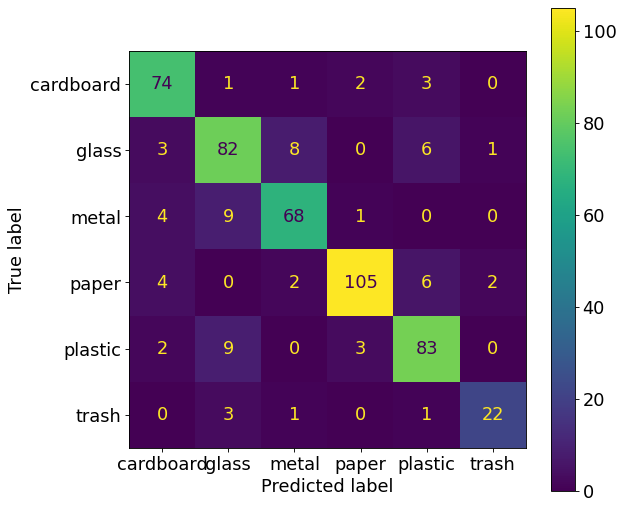

In [ ]:
# Inception-ResNetV2-5,10,5 (RMSprop)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
plt.rcParams.update({'font.size': 16})
disp.plot(ax=ax)

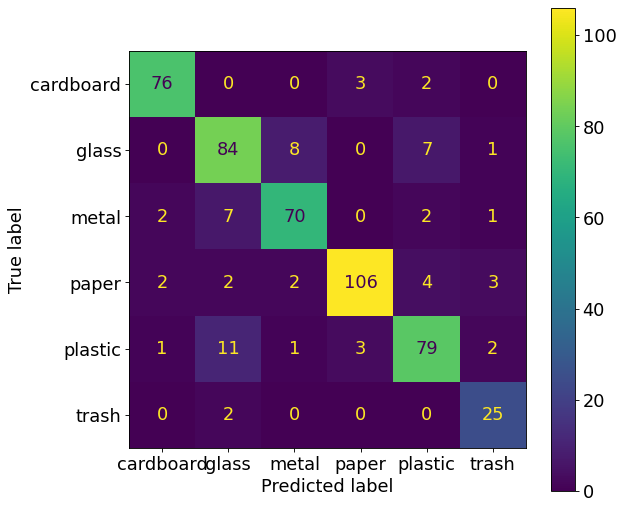

In [ ]:
# Inception-ResNetV2-5,10,5 (Adam)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

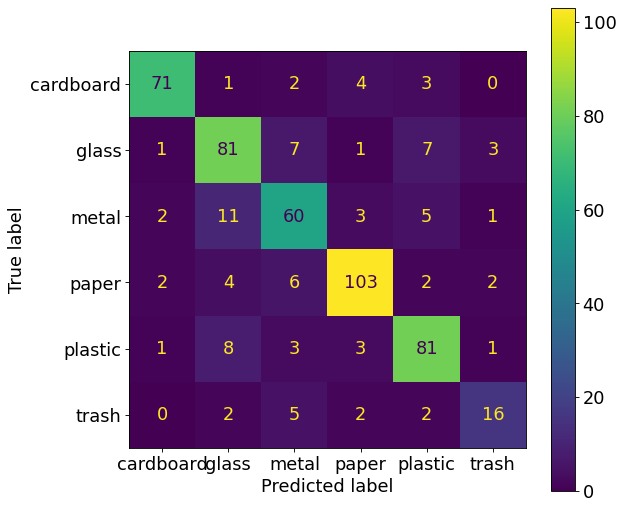

In [ ]:
# Inception-ResNetV2-5,10,5 (SGD)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

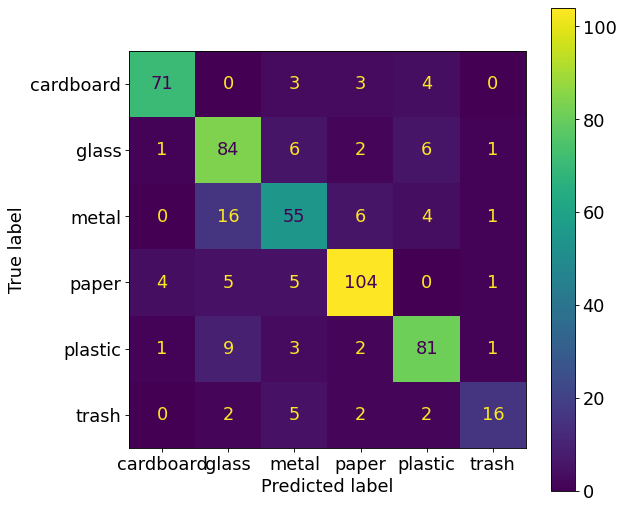

In [ ]:
# Inception-ResNetV2-5,10,5 (SGD + Nesterov)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

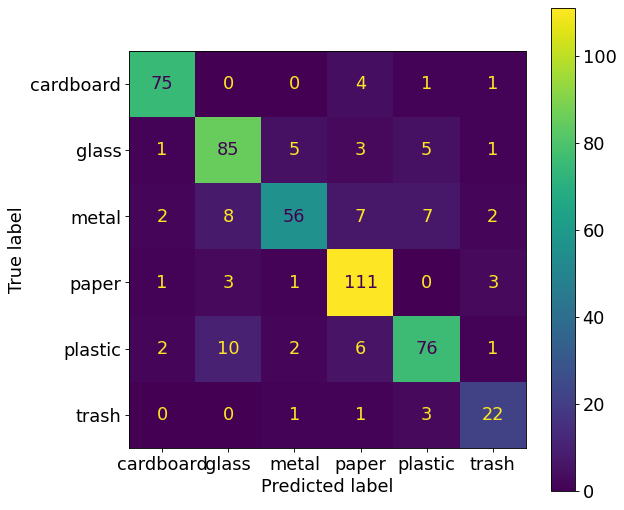

In [ ]:
# Inception-ResNetV2-5,10,5 (Adagrad)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

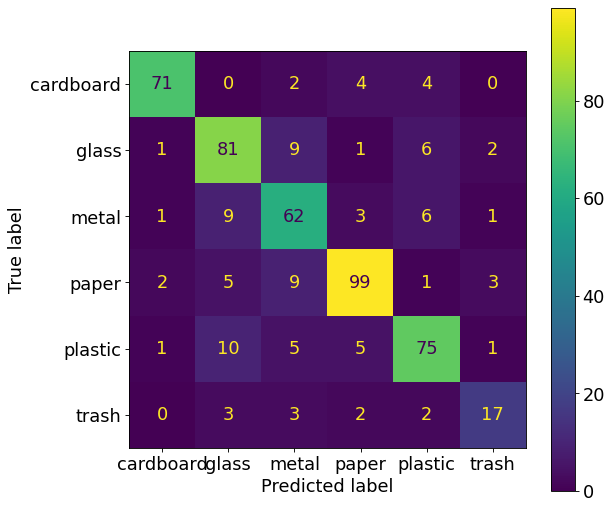

In [ ]:
# Inception-ResNetV2-5,10,5 (Adadelta)
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
plt.rcParams.update({'font.size': 16})
disp.plot(ax=ax)

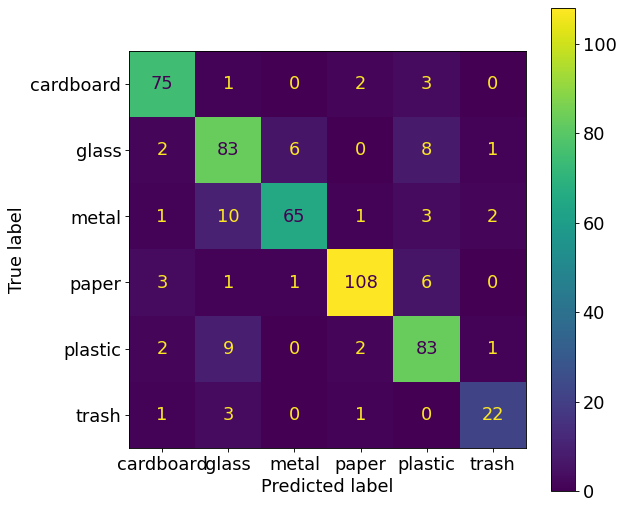

In [ ]:
# Inception-ResNetV2-4,9,4 (Adam)
plt.rcParams.update({'font.size': 16})
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

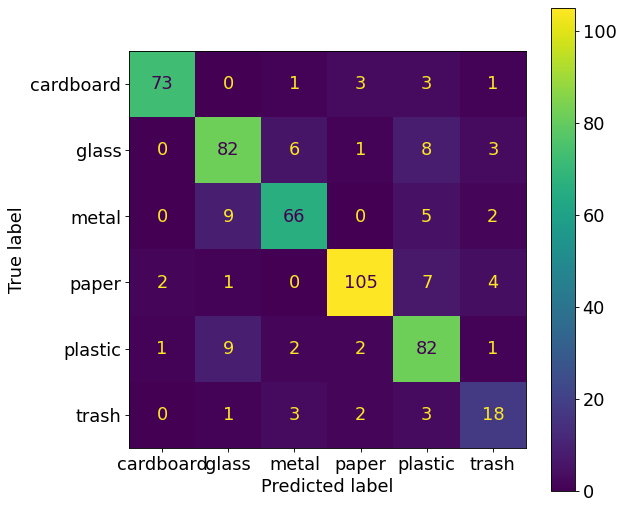

In [ ]:
# Inception-ResNetV2-3,8,3 (Adam)
plt.rcParams.update({'font.size': 16})
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

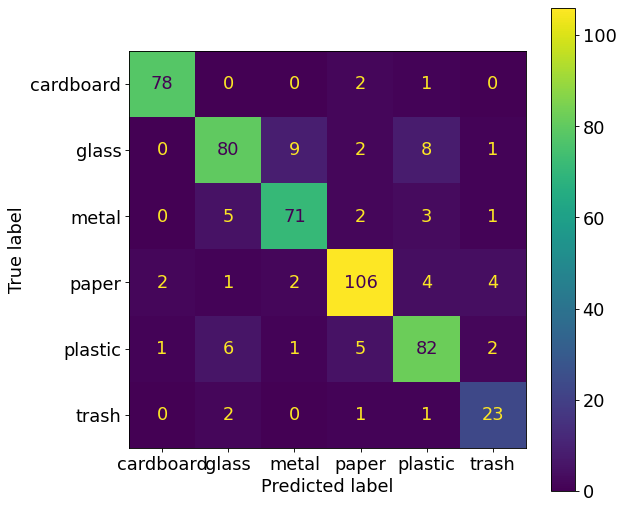

In [19]:
# Inception-ResNetV2-2,7,2 (Adam)
plt.rcParams.update({'font.size': 16})
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

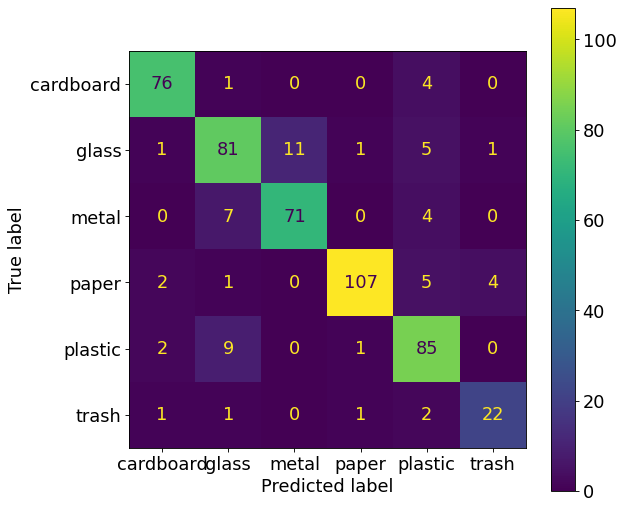

In [34]:
# Inception-ResNetV2-1,6,1 (Adam)
plt.rcParams.update({'font.size': 16})
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)

## Grad Cam

(128, 128, 3)


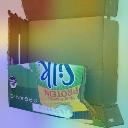

In [40]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)
    img = np.float32(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    print(img.shape)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

# 5, 10, 58, 79, 78, 13
i = 5
heatmap = make_gradcam_heatmap(np.expand_dims(img_train[i,:,:,:], axis=0), model1, "incResC_0_act_scaling")   # incResC_4_act_scaling
save_and_display_gradcam(img_train[i,:,:,:]*255, heatmap)

In [20]:
model1.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1conv2d (Conv2D)           (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 conv1conv2d_bn (BatchNormaliza  (None, 63, 63, 32)  96          ['conv1conv2d[0][0]']            
 tion)                                                                                            
                                                                                

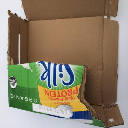

cardboard


In [ ]:
cv2_imshow(img_train[5]*255)
print(label_train[5])

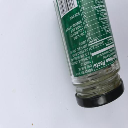

glass


In [ ]:
cv2_imshow(img_train[10]*255)
print(label_train[10])

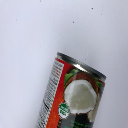

metal


In [ ]:
cv2_imshow(img_train[58]*255)
print(label_train[58])

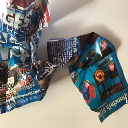

paper


In [ ]:
cv2_imshow(img_train[79]*255)
print(label_train[79])

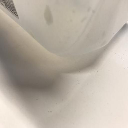

plastic


In [ ]:
cv2_imshow(img_train[78]*255)
print(label_train[78])

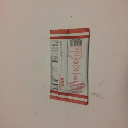

trash


In [ ]:
cv2_imshow(img_train[13]*255)
print(label_train[13])